# Sample a probability density with Neal's funnel using HMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js

import numpyro
import numpyro.distributions as dist

import torch
from torch import tensor
import zuko
import random
import pyro
from pyro import distributions as pyro_dist

from flowjax.bijections import Affine, RationalQuadraticSpline
from flowjax.distributions import StandardNormal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_key_based_loss
import equinox as eqx

from corner import corner

We model parameters $\vec{x}$, and $y$ jointly. We take $\vec{x}\in\mathbb{R}^2$ and $y\in\mathbb{R}$. The joint probability density is

\begin{equation*}
    p(\vec{x}, y) \propto p(\vec{x} | y) \cdot p(y)\,.
\end{equation*}

We choose distributions,

\begin{equation*}
    p(\vec{x} | y) \sim \mathcal{N}(\vec{\mu}=\vec{0}, \Sigma=e^{y}\,\mathbb{I})
\end{equation*}

and

\begin{equation*}
    p(y) \sim \mathcal{N}(\mu=0, \sigma=3)\,.
\end{equation*}

In [2]:
x_dim = 6  # dimension of x random variable
mean = jnp.ones(x_dim)
scale = 2. * jnp.ones(x_dim)
@jit
def lnlike(x):
    return js.stats.norm.logpdf(x, loc=mean)

In [3]:
# define joint probability density
@jit
def ln_pdf(x, y):
    lnpy = js.stats.norm.logpdf(y, loc=0., scale=3.)
    lnpxy = js.stats.multivariate_normal.logpdf(x, jnp.zeros(x_dim), jnp.exp(y) * jnp.eye(x_dim))
    return lnpxy + lnpy

In [4]:
# sample funnel with HMC
def neals_funnel():
    x = numpyro.sample('x', dist.Uniform(-1000., 1000.).expand((x_dim,)))
    y = numpyro.sample('y', dist.Uniform(-1000., 1000.))
    numpyro.factor('ln_pdf', ln_pdf(x, y))

nuts_kernel = numpyro.infer.NUTS(neals_funnel,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(1e4))
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
samples = np.concatenate((samples_dict['x'],
                          samples_dict['y'][:, None]),
                          axis=1,
                          )

sample: 100%|██████████| 20000/20000 [00:05<00:00, 3865.43it/s, 31 steps of size 1.66e-01. acc. prob=0.40]


In [5]:
# standardize funnel for better sampling
def neals_funnel_standardized():
    # sample from standard normal distribution
    x_normal = numpyro.sample('x_normal', dist.Normal().expand((x_dim,)))
    y_normal = numpyro.sample('y_normal', dist.Normal())

    # transform to prior distributions
    y = y_normal * 3.0
    x = x_normal * jnp.exp(y / 2.)
    numpyro.deterministic('x', x)
    numpyro.deterministic('y', y)

nuts_kernel_st = numpyro.infer.NUTS(neals_funnel_standardized,
                                    dense_mass=True)
mcmc_st = numpyro.infer.MCMC(sampler=nuts_kernel_st,
                             num_warmup=int(1e4),
                             num_samples=int(1e5))
mcmc_st.run(jr.key(1))
samples_dict_st = mcmc_st.get_samples()
samples_st = np.concatenate((samples_dict_st['x'],
                             samples_dict_st['y'][:, None]),
                             axis=1,
                             )

sample: 100%|██████████| 110000/110000 [00:14<00:00, 7805.44it/s, 7 steps of size 7.46e-01. acc. prob=0.89]


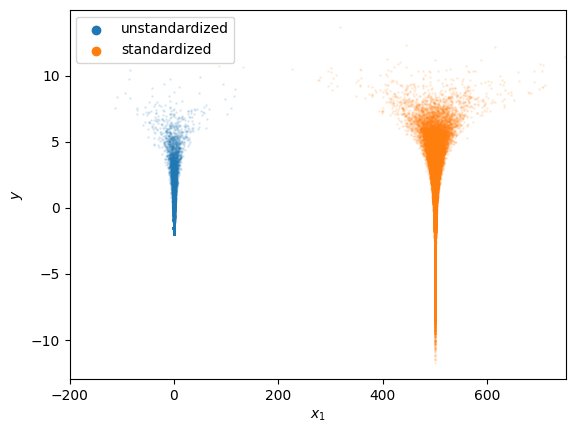

In [6]:
# plot samples
ndx1 = 0
ndx2 = -1
x_labels = np.array([rf'$x_{{{i}}}$' for i in np.arange(1, x_dim + 1)])
labels = np.concatenate((x_labels, np.array([r'$y$'])))
plt.scatter(samples[:, ndx1], samples[:, ndx2], s=1, alpha=0.1)
plt.scatter(500 + samples_st[:, ndx1], samples_st[:, ndx2], s=1, alpha=0.1)
plt.scatter([], [], color='C0', label='unstandardized')
plt.scatter([], [], color='C1', label='standardized')
plt.xlim(-200, 750)
plt.xlabel(labels[ndx1])
plt.ylabel(labels[ndx2])
plt.legend()
plt.show()

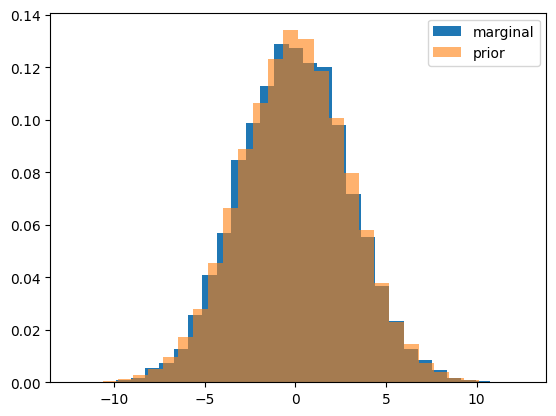

In [7]:
# plot marginal distribution of hyper-parameter y and its prior
plt.hist(samples_st[::10, -1], bins=30, color='C0', density=True, label='marginal')
plt.hist(jr.normal(jr.key(0), 100_000) * 3, bins=30,
         color='C1', alpha=0.6, density=True, label='prior')
plt.legend()
plt.show()

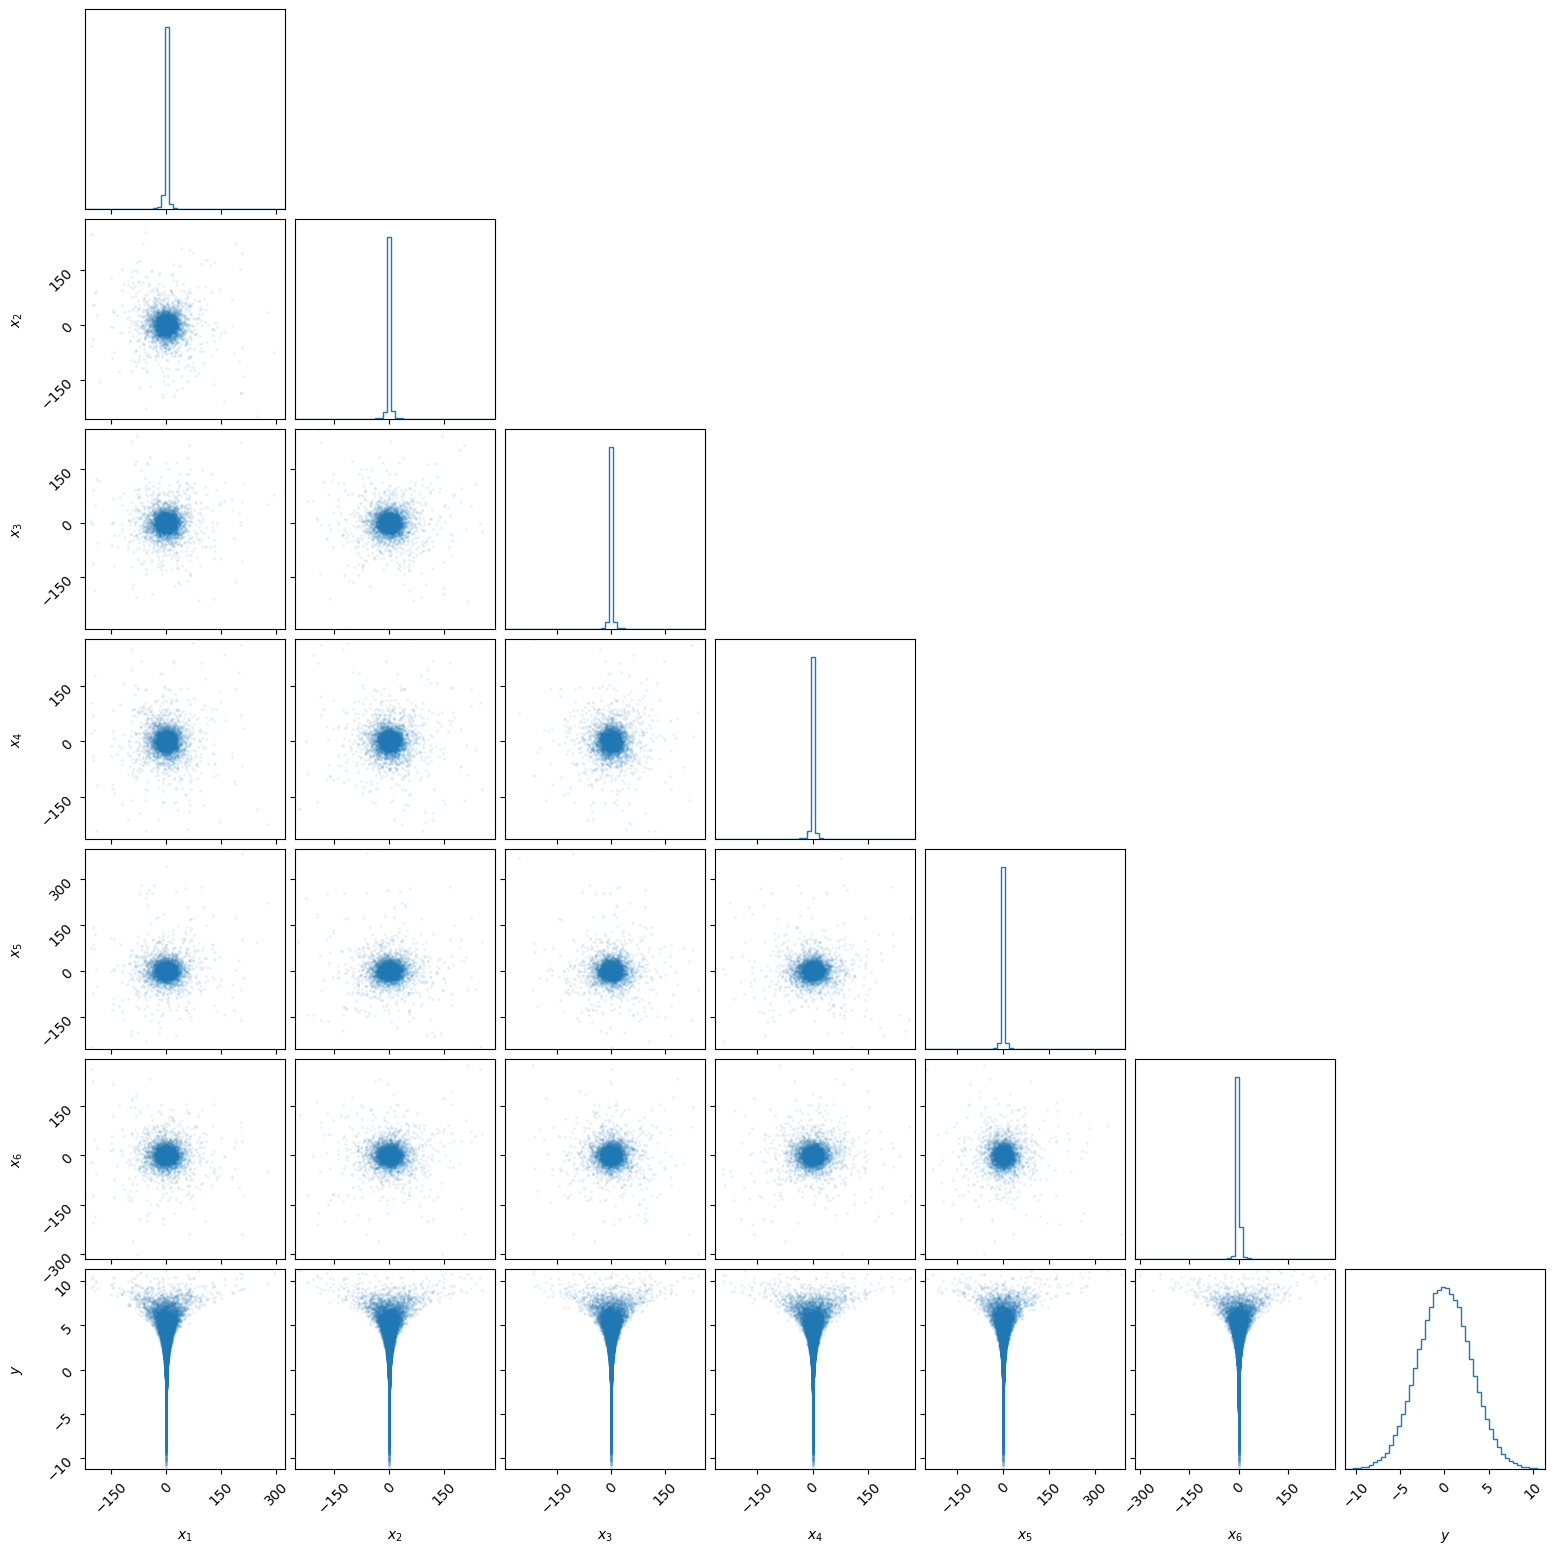

In [8]:
fig = corner(samples_st,
             labels=labels,
             range=[0.9999]*samples_st.shape[1],
             color='C0',
             plot_contours=False,
             plot_density=False,
             bins=50)

Instead of sampling over $y$ which leads to a strong funnel, we sample the "extended" density,

\begin{equation*}
    p(\vec{x}, \vec{z}) \propto p(\vec{x} | \vec{z})\cdot p(\vec{z})
\end{equation*}

where $\vec{z}\in\mathbb{R}^2$ with

\begin{equation*}
    p(\vec{x} | \vec{z}) \sim \mathcal{N}(\vec{\mu}=\vec{0}, \Sigma=\text{diag}(\vec{z}))
\end{equation*}

and the prior on $z$ is chosen to respect the coordinate transformation.

In [48]:
def extended_model():
    # sample in log-z
    log10_z = numpyro.sample('log10_z', dist.Uniform(-4., 4.).expand((x_dim,)))
    # conditional prior on x
    x_standard = numpyro.sample('x_standard', dist.Normal().expand((x_dim,)))
    x = numpyro.deterministic('x', x_standard * jnp.sqrt(10. ** log10_z))

nuts_kernel_extended = numpyro.infer.NUTS(extended_model,
                                          dense_mass=False)
mcmc_extended = numpyro.infer.MCMC(sampler=nuts_kernel_extended,
                                      num_warmup=int(1e4),
                                      num_samples=int(1e5))
mcmc_extended.run(jr.key(2))
samples_dict_extended = mcmc_extended.get_samples()
extended_samples = np.concatenate((samples_dict_extended['x'],
                                   samples_dict_extended['log10_z']),
                                   axis=1)

sample: 100%|██████████| 110000/110000 [00:15<00:00, 7211.34it/s, 7 steps of size 6.42e-01. acc. prob=0.87]


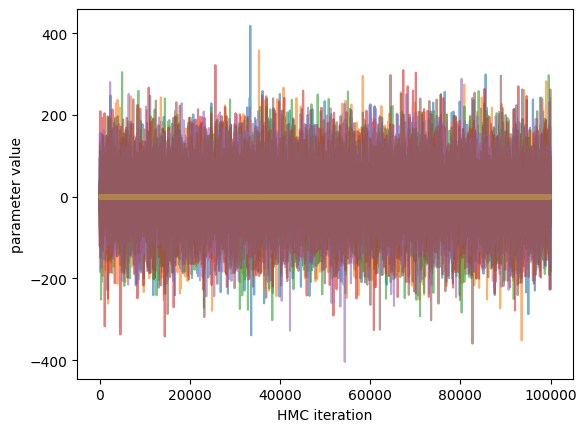

In [49]:
z_labels = np.array([rf'$\log_{{{10}}}\,z_{{{i}}}$' for i in np.arange(1, x_dim + 1)])
extended_labels = np.concatenate((x_labels, z_labels))
for i, label in enumerate(extended_labels):
    plt.plot(extended_samples[:, i], color=f'C{i}',
             alpha=0.6, label=label)
plt.xlabel('HMC iteration')
plt.ylabel('parameter value')
# plt.legend()
plt.show()

In [50]:
# burnin = 30_000
burnin = 0

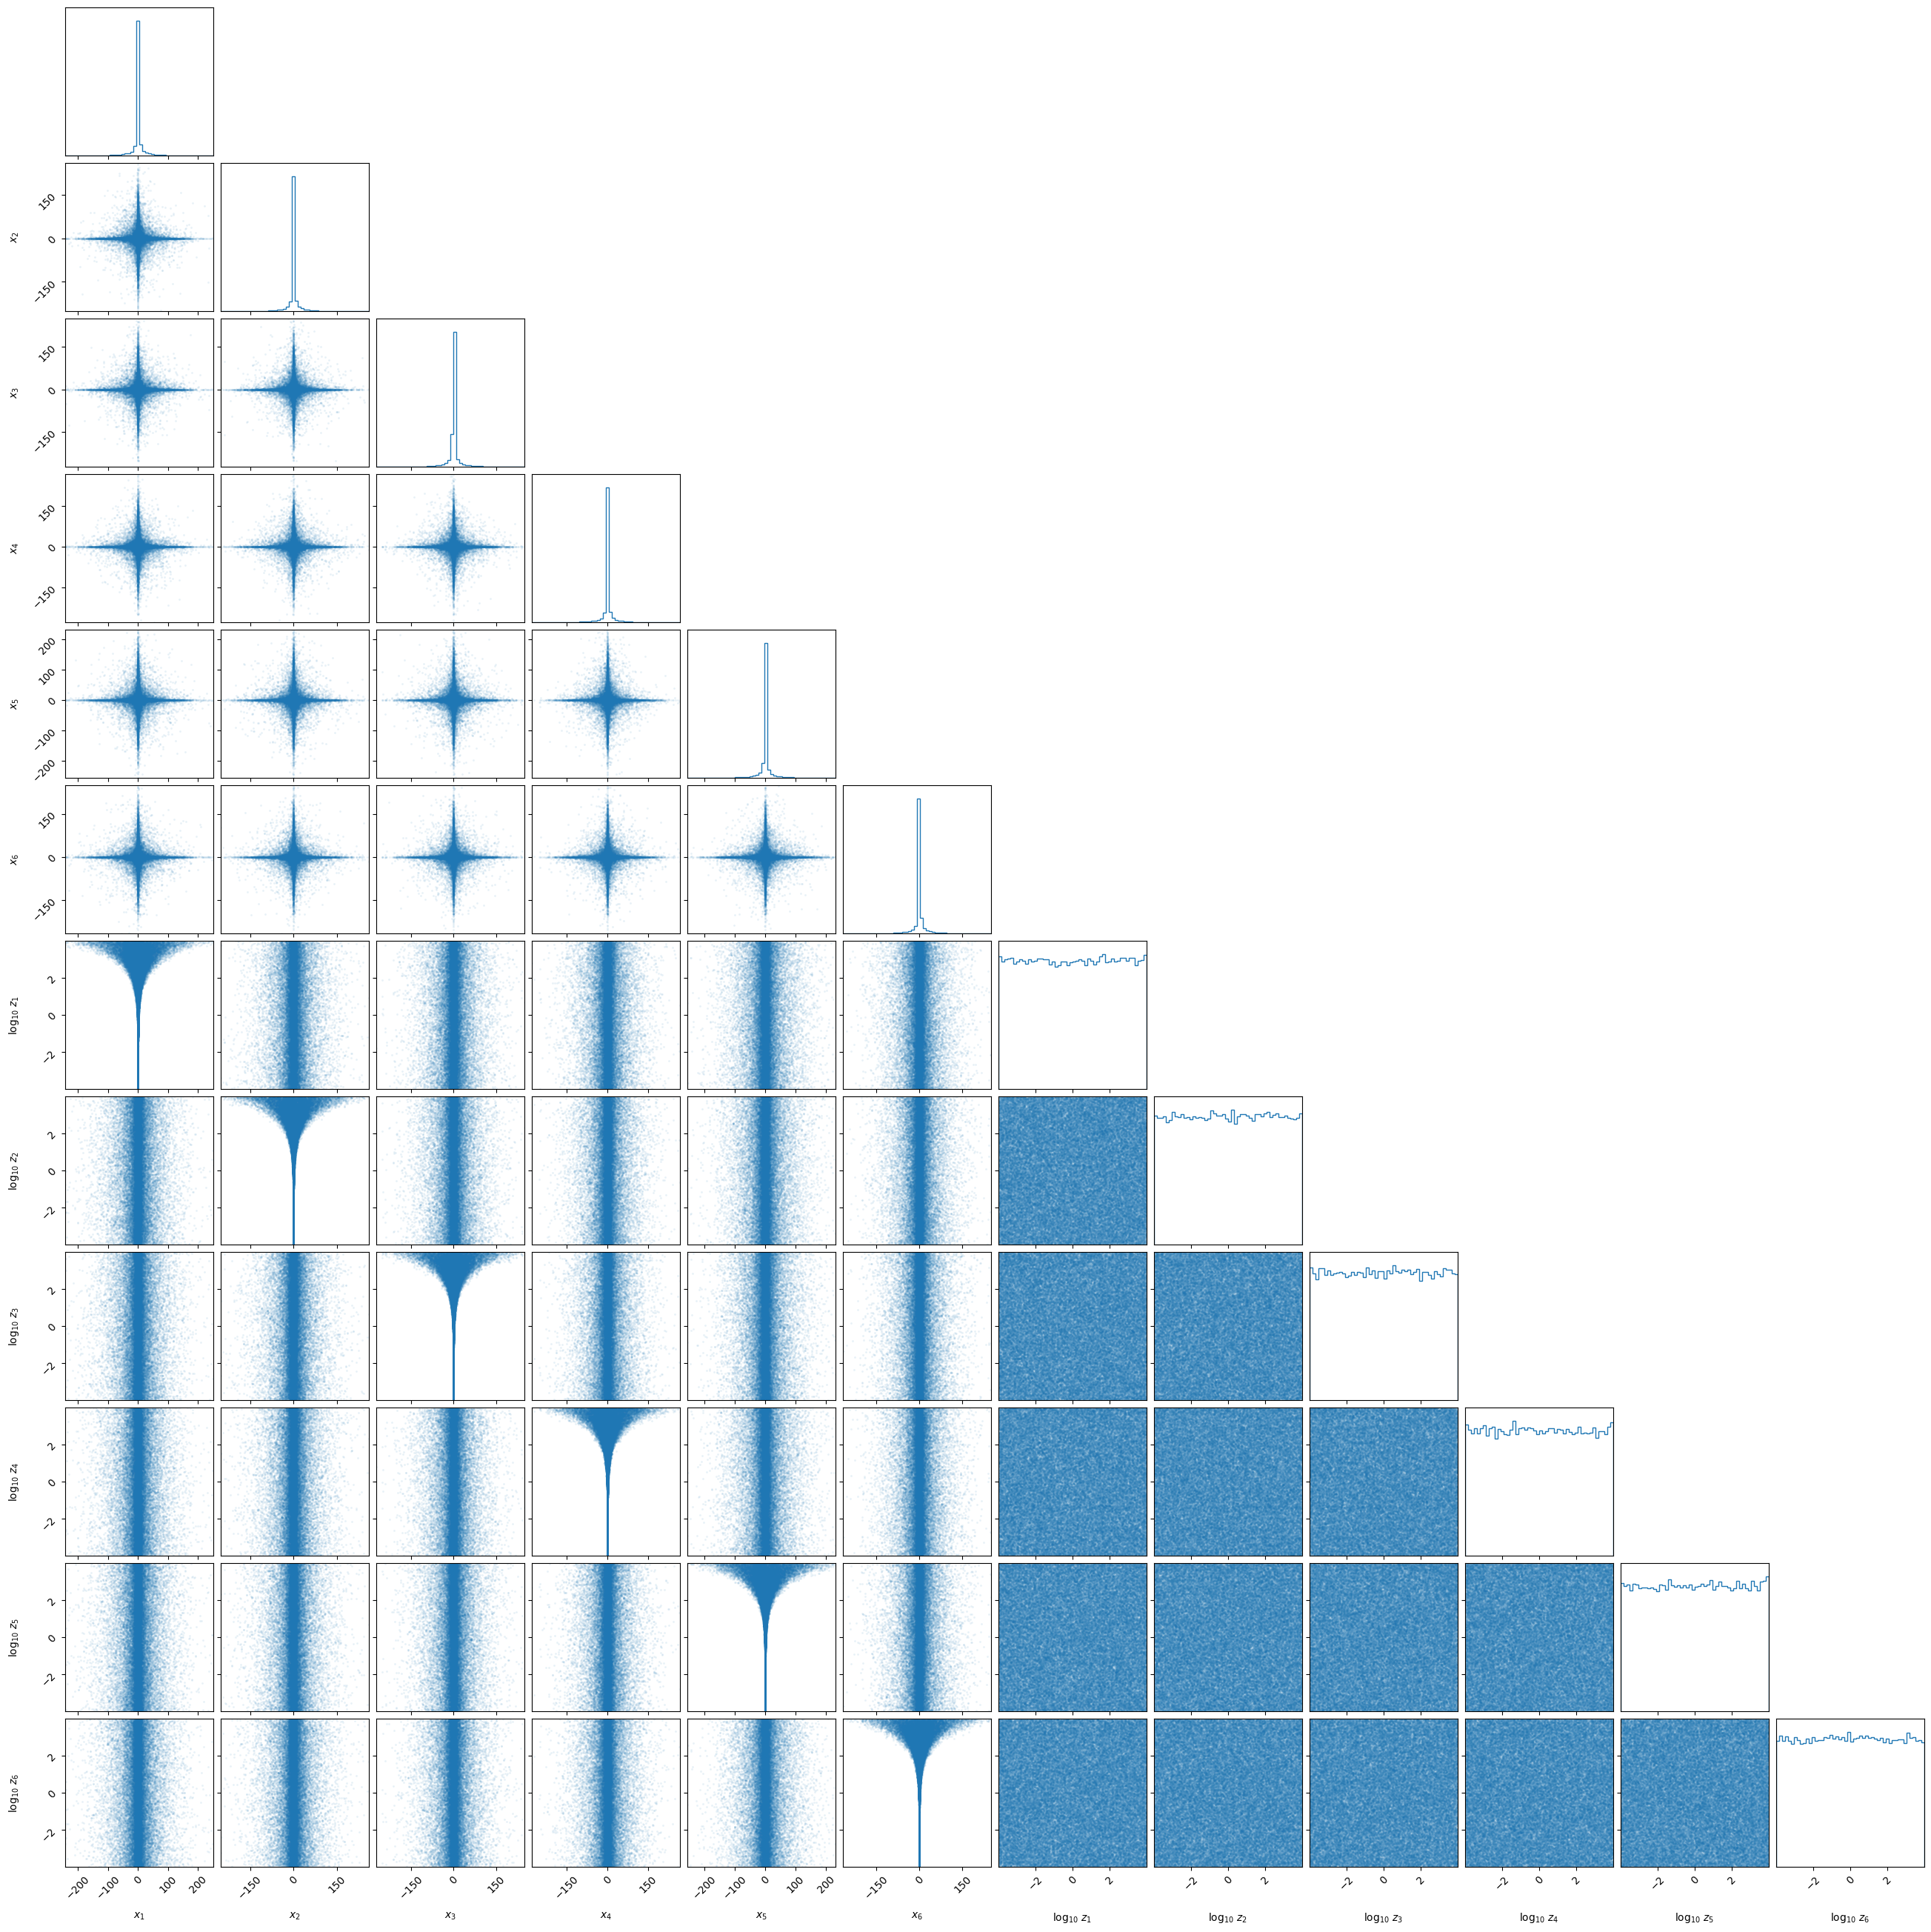

In [51]:
fig = corner(extended_samples[burnin::1],
             labels=extended_labels,
             range=[0.9999]*extended_samples.shape[1],
             color='C0',
             plot_contours=False,
             plot_density=False,
             bins=50)

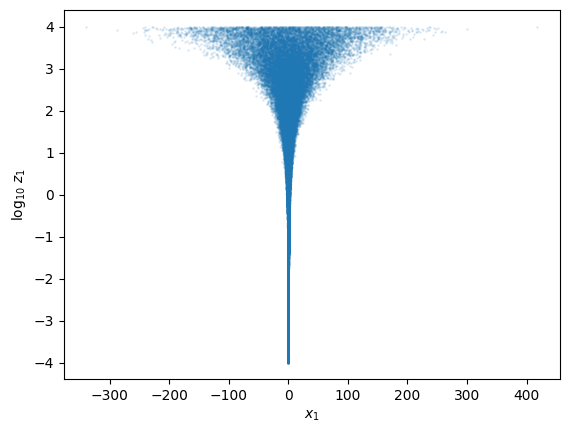

In [52]:
ndx1 = 0
ndx2 = x_dim
plt.scatter(extended_samples[:, ndx1], extended_samples[:, ndx2],
            color='C0', s=1, alpha=0.1)
plt.xlabel(extended_labels[ndx1])
plt.ylabel(extended_labels[ndx2])
plt.show()

## Second stage sampling

Now we model $\vec{z}=e^{y/2}\,\mathbb{I}$. First we need to learn the distribution on $\vec{z}$ with a normalizing flow.

In [53]:
log10_z_samples = torch.tensor(extended_samples[:, x_dim:])

In [54]:
# transformation to "normalized" samples
B = 4
max_val = torch.max(log10_z_samples, axis=0).values
min_val = torch.min(log10_z_samples, axis=0).values
h = (max_val - min_val) / 2
mean_val = (max_val + min_val) / 2

def normalize(sample):
    return B * (sample - mean_val) / h

def unnormalize(sample):
    return sample * h / B + mean_val

/var/folders/66/w_x_69897j7fl6qw22pxkywc0000gn/T/ipykernel_57147/1709287148.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_samples = torch.tensor(normalize(log10_z_samples),


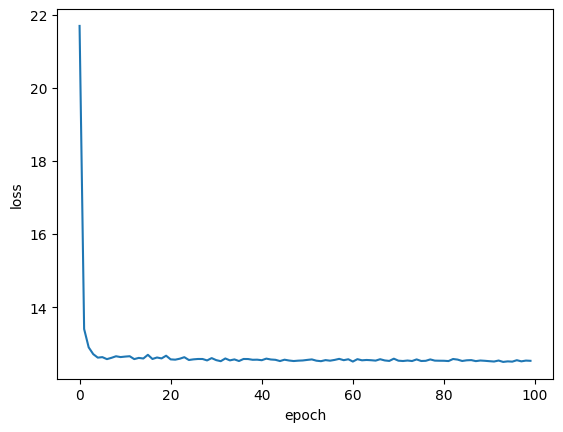

In [64]:
torch.set_default_dtype(torch.float64)

# define flow
flow = zuko.flows.spline.NSF(features=x_dim,
                             context=0,
                             bins=8,
                             passes=2,
                             hidden_features=[512] * 4)

normalized_samples = torch.tensor(normalize(log10_z_samples),
                                  device='cpu',
                                  dtype=torch.float64)
batch_size = 256
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
losses = []
num_epoch = int(1e3)
for epoch in range(num_epoch):

    idx = random.sample(range(normalized_samples.shape[0]), k=batch_size)
    fair_draws = normalized_samples[idx]

    loss = -flow().log_prob(fair_draws).mean()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if epoch % 10 == 0:
        print(f'{np.round(epoch / num_epoch * 100, 3)}%   loss = {loss.item()}', end='\r')
        losses.append(loss.item())
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [65]:
normalized_flow_samples = flow().sample((int(1e5),))
flow_samples = unnormalize(normalized_flow_samples)

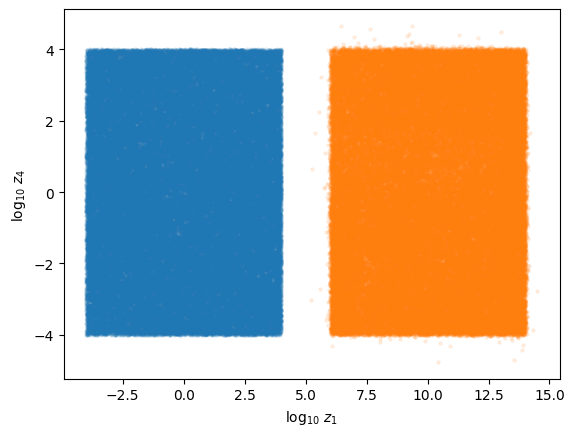

In [66]:
# plot flow samples
ndx1 = 0
ndx2 = 3
plt.scatter(log10_z_samples[:, ndx1], log10_z_samples[:, ndx2],
         color='C0', alpha=0.1, s=5, label='HMC samples')
plt.scatter(flow_samples[:, ndx1] + 10, flow_samples[:, ndx2],
         color='C1', alpha=0.1, s=5, label='normalizing flow')
plt.xlabel(z_labels[ndx1])
plt.ylabel(z_labels[ndx2])
plt.show()

In [67]:
# second stage density
def second_stage_lnpost(y):
    # prior 
    lnprior = -0.5 * (y / 3.)**2.
    # likelihood
    lnlike = flow().log_prob(normalize(torch.log10(torch.ones(x_dim) * torch.exp(y / 2.))))
    return lnprior + lnlike

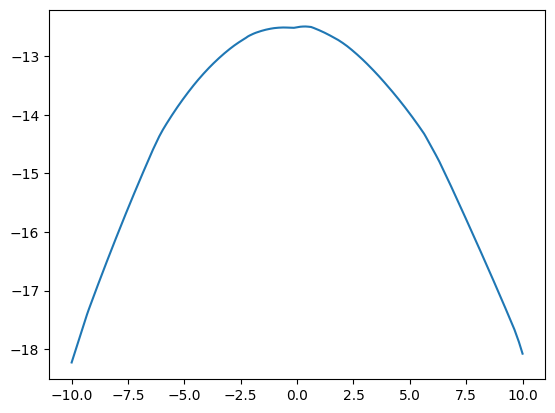

In [68]:
y_vals = torch.linspace(-10, 10, 500)
lnposts = np.array([second_stage_lnpost(y).item() for y in y_vals])
plt.plot(y_vals.detach().numpy(), lnposts)
plt.show()

In [69]:
# do HMC NUTS with Pyro
def second_stage_sampling_model():
    y = pyro.sample('y', pyro_dist.Uniform(-20., 20.))
    pyro.factor('lnpost', second_stage_lnpost(y))

pyro_nuts_kernel = pyro.infer.NUTS(model=second_stage_sampling_model,
                                   full_mass=True)
pyro_mcmc = pyro.infer.MCMC(kernel=pyro_nuts_kernel,
                            warmup_steps=500,
                            num_samples=int(1e4))
pyro_mcmc.run()
y_samples = pyro_mcmc.get_samples()['y']

Sample: 100%|██████████| 10500/10500 [02:51, 61.11it/s, step size=1.01e+00, acc. prob=0.909]


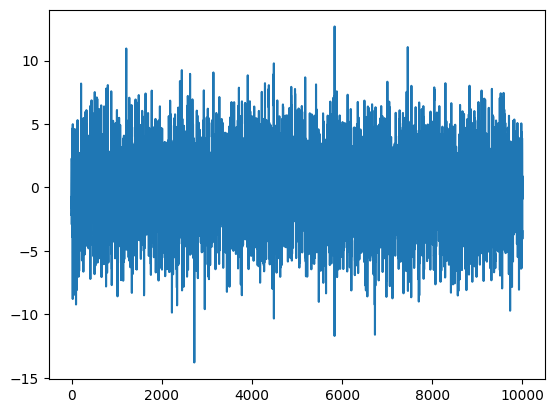

In [70]:
plt.plot(y_samples)

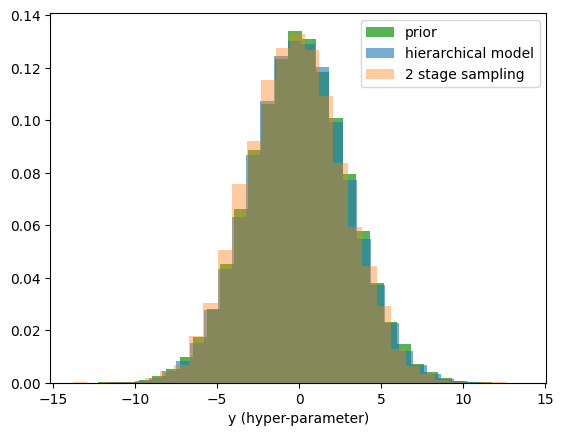

In [72]:
nbins = 30
plt.hist(jr.normal(jr.key(0), 100_000) * 3, bins=30,
         color='C2', alpha=0.8, density=True, label='prior')
plt.hist(samples_st[:, -1], bins=nbins, density=True,
         label='hierarchical model', alpha=0.6)
plt.hist(y_samples.detach().numpy()[::1], bins=nbins, alpha=0.4, density=True, label='2 stage sampling')
plt.xlabel('y (hyper-parameter)')
plt.legend()
plt.show()